# Implementation: Linear Regression

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

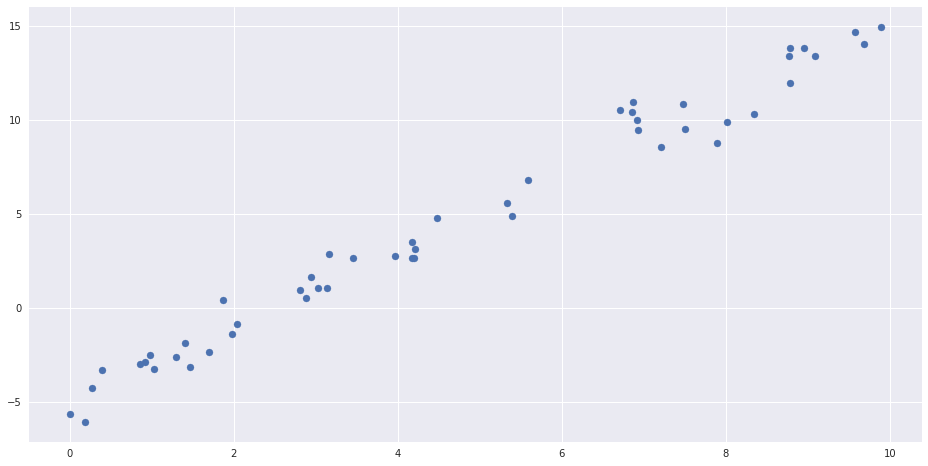

In [12]:
rng = np.random.RandomState(1)
x_train = 10 * rng.rand(50)
y_train = 2 * x_train - 5 + rng.randn(50)
plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train);

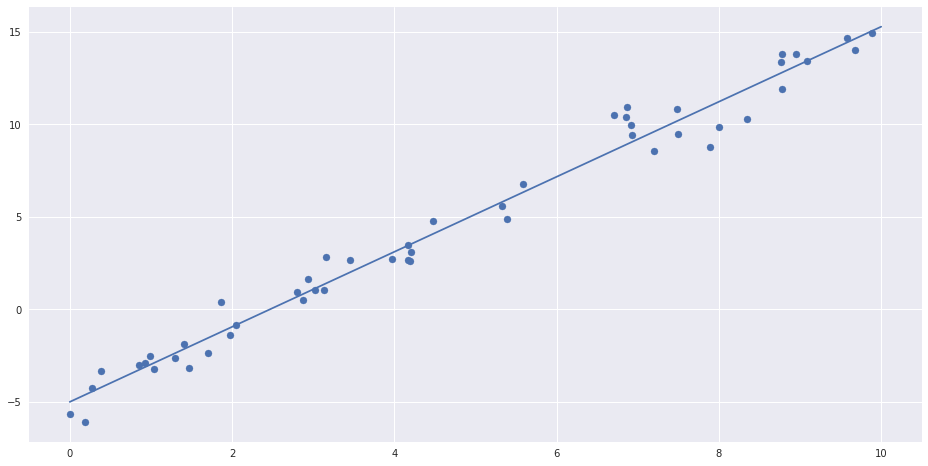

In [15]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x_train[:, np.newaxis], y_train)

x_test = np.linspace(0, 10, 1000)
y_estimated = model.predict(x_test[:, np.newaxis])

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, y_estimated);

In [16]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.02720881036
Model intercept: -4.99857708555


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


## Basis Function Regression

To adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.


The idea is to take multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

$$\text{We let   } x_n = f_n(x) \text{  , where    } f_n(x)  \text{  is some function that transforms our data.  }$$


take our one-dimensional $x$ values and projected them into a higher dimension

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$



### Polynomial basis functions


In [17]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [18]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

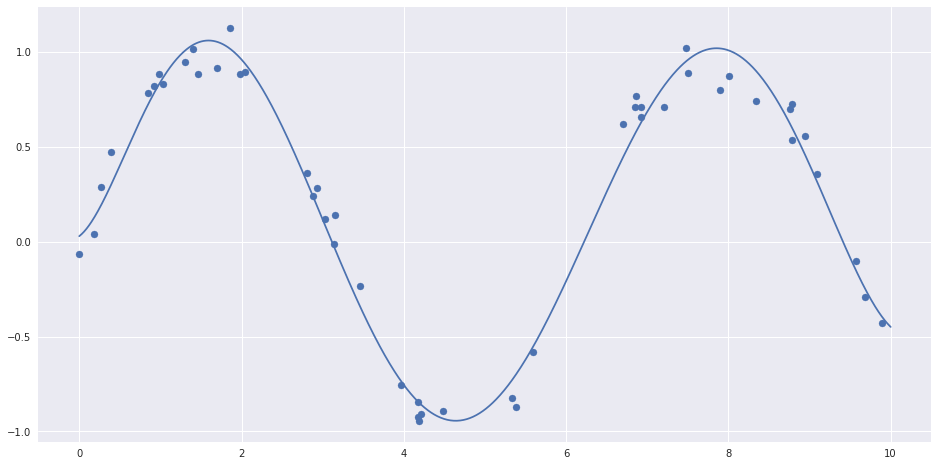

In [20]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.figure(figsize=(16,8))
plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian basis functions


For example, one useful pattern is to fit a model that is a sum of Gaussian bases.


(-1.5, 1.5)

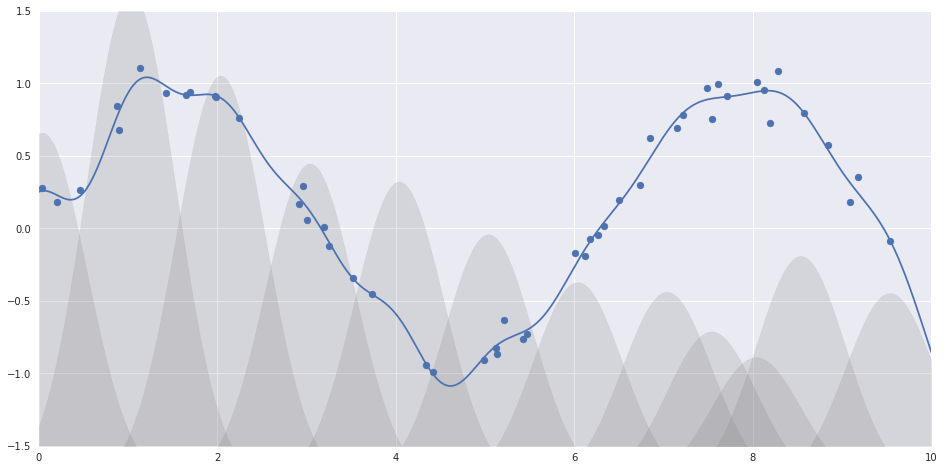

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt


class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, order, width_factor=2.0):
        self.order=order
        self.stddev_factor=width_factor

    def gaussian_basis(self, x, y, stddev, axis= None):
        arg = (x - y) / stddev
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y): # make it private
        self.mu=np.linspace(X.min(), X.max(), self.order)
        self.stddev=self.stddev_factor*(self.mu[1]-self.mu[0])
        return self

    def transform(self, X):
        return self.gaussian_basis(X[:,:, np.newaxis], self.mu, self.stddev, axis=1)

rs=np.random.RandomState(10)
order=20

x_train=10*rs.rand(50)
y_train=np.sin(x_train)+0.1*rs.randn(50) # add white noise

x_test = np.linspace(0, 10, 1000)

gauss_model = make_pipeline(GaussianFeatures(order, 1.0),
                            LinearRegression())

gauss_model.fit(x_train[:, np.newaxis], y_train)


y_estimated=gauss_model.predict(x_test[:, np.newaxis])

gf=gauss_model.named_steps['gaussianfeatures']
lr=gauss_model.named_steps['linearregression']

fig, ax=plt.subplots(figsize=(16,8))

for i in range(order):
    encoder = np.zeros(order)
    encoder[i] = 1
    X_test = gf.transform(x_test[:, None]) * encoder
    Y_estimated=lr.predict(X_test)
    ax.fill_between(x_test, Y_estimated.min(), Y_estimated, color='gray', alpha=0.2)

ax.scatter(x_train,y_train)
ax.plot(x_test,y_estimated)

ax.set_xlim(0,10)
ax.set_ylim(-1.5, 1.5)


__The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.__


## Regularization

Basis functions makes the model much more flexible, but it also can very quickly lead to over-fitting:

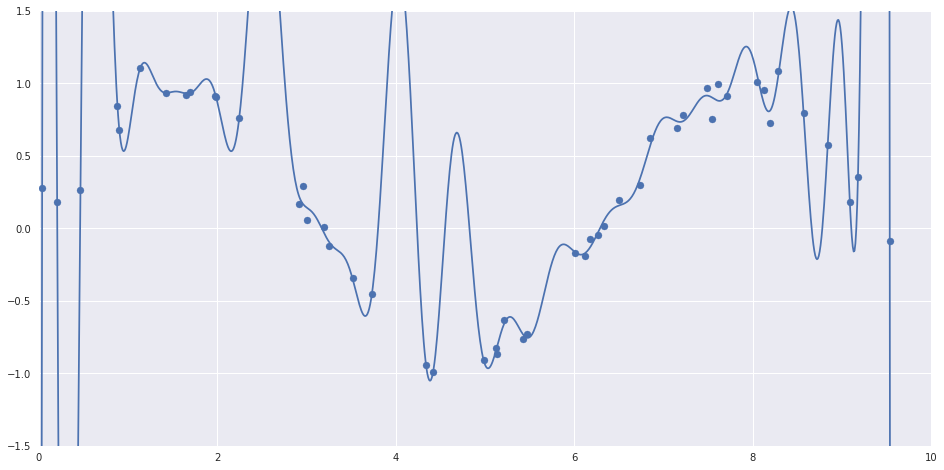

In [40]:
model = make_pipeline(GaussianFeatures(40),
                      LinearRegression())
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

### Ridge regression (L2 Regularization)

The most common form of regularization is known as *ridge regression* or L2 *regularization*.

penalizing the sum of squares (2-norms) of the model coefficients

in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$


__where alpha is a free parameter that controls the strength of the penalty.__


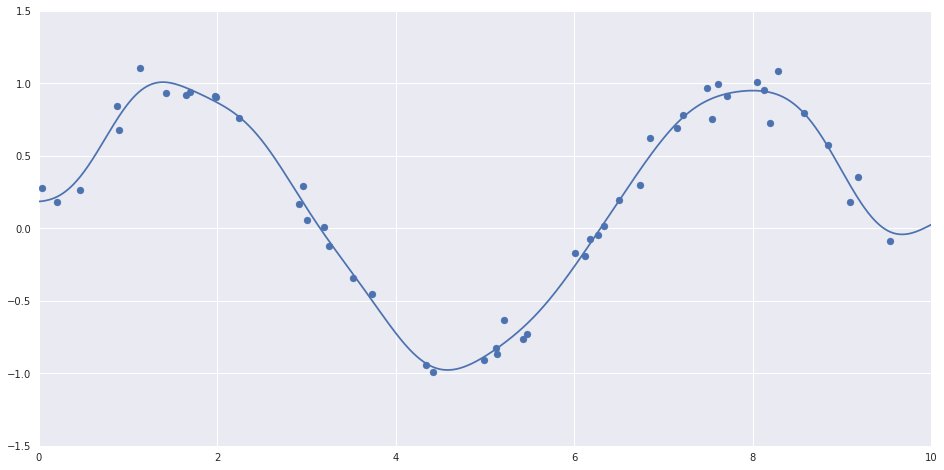

In [42]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(40), Ridge(alpha=0.1))
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

$$ \text{ The  } \alpha \text{   parameter is essentially controlling the complexity of the resulting model.}$$



One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression (L1 regularization)


$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Due to geometric reasons lasso regression tends to favor **sparse models** where possible

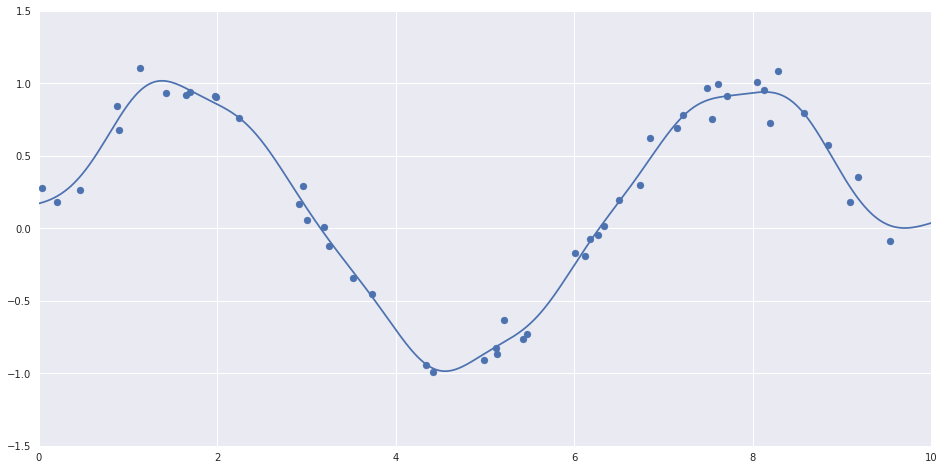

In [41]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(40), Lasso(alpha=0.001))
model.fit(x_train[:, np.newaxis], y_train)

plt.figure(figsize=(16,8))
plt.scatter(x_train, y_train)
plt.plot(x_test, model.predict(x_test[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

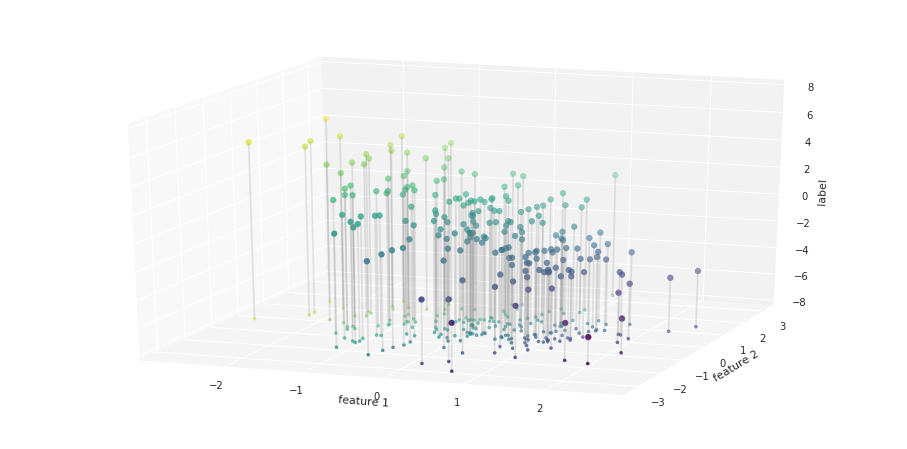

In [66]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

x_train = rng.randn(200, 2)
y_train = np.dot(x_train, [-2, 1]) + 0.1 * rng.randn(x_train.shape[0])

points = np.hstack([x_train, y_train[:, None]]).reshape(-1, 1, 3)
segments = np.hstack([points, points])
segments[:, 0, 2] = -8


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:, 0], x_train[:, 1], y_train, c=y_train, s=35,
           cmap='viridis')
ax.add_collection3d(Line3DCollection(segments, colors='gray', alpha=0.2))
ax.scatter(x_train[:, 0], x_train[:, 1], -8 + np.zeros(x_train.shape[0]), c=y_train, s=10,
           cmap='viridis')

# format plot
ax.patch.set_facecolor('white')
ax.view_init(elev=20, azim=-70)
ax.set_zlim3d(-8, 8)

ax.set(xlabel='feature 1', ylabel='feature 2', zlabel='label')


for tick in ax.w_xaxis.get_ticklines():
    tick.set_visible(False)
for tick in ax.w_yaxis.get_ticklines():
    tick.set_visible(False)
for tick in ax.w_zaxis.get_ticklines():
    tick.set_visible(False)


In [67]:
def format_plot(ax, title):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xlabel('feature 1', color='gray')
    ax.set_ylabel('feature 2', color='gray')
    ax.set_title(title, color='gray')

## Example: Predicting Bicycle Traffic

In [14]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
# wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

In [79]:
import pandas as pd
import os
PATH='/home/karen/Downloads/data'
counts = pd.read_csv(os.path.join(PATH,'FremontBridge.csv'), index_col='Date', parse_dates=True)
weather = pd.read_csv(os.path.join(PATH,'BicycleWeather.csv'), index_col='DATE', parse_dates=True)

In [80]:
counts.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4,9
2012-10-03 01:00:00,4,6
2012-10-03 02:00:00,1,1
2012-10-03 03:00:00,2,3
2012-10-03 04:00:00,6,1


In [81]:
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [95]:
daily['Total'] = counts.sum(axis=1) # row sum
daily = daily[['Total']] # remove other columns

In [96]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

AttributeError: 'Index' object has no attribute 'dayofweek'

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

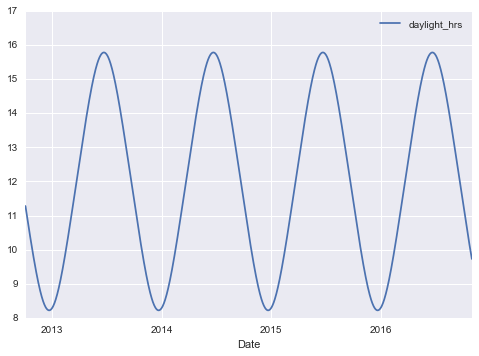

In [19]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [20]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [21]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [23]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

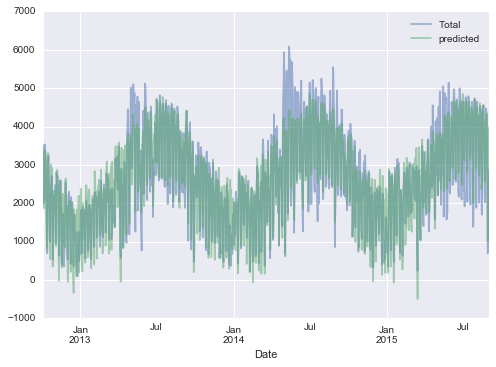

In [24]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [25]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [26]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [27]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays.
We see that for each additional hour of daylight, 129 ± 9 more people choose to ride; a temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home.
Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

<!--NAVIGATION-->
< [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb) | [Contents](Index.ipynb) | [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) >